# Text mining project
## Goals
• Gain practical experience with the complete data mining process

• Get to know additional problem-specific

• Pre-processing methods

• data mining methods
## Expectation
• Select an interesting data mining problem of your choice

• Solve the problem using

• the data mining methods that we have learned so far, including

• proper parameter optimization

• problem-specific pre-processing and smart feature creation

• additional data mining methods which might be helpful for solving the problem

# Importations.

## NLTK

In [38]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk.tag import pos_tag

from nltk.tokenize import word_tokenize

from nltk.probability import FreqDist

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Sklearn

In [39]:
# Sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

## Classifier
from sklearn.naive_bayes import (
    BernoulliNB,
    ComplementNB,
    MultinomialNB,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.inspection import DecisionBoundaryDisplay

## Autre

In [40]:
from bs4 import BeautifulSoup # suppression des balises html.
import codecs # lire les fichiers.
import contractions
import copy
import os # manipulation des fichiers et des dossiers.
import re # utilisation de regex.
import sys # quitter le programme en cas d'erreur.
import string # suppression de la ponctuation.
from tqdm import tqdm
import pandas as pd # DataFrame, ...
import numpy as np # array, ...
# Visualistion
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud

# Variables globales.

In [41]:
DEBUG = False
TEST = 3000
MAX_FEATURES = 1500
OUT_CSV = "./out/csv/"
OUT_IMG = "./out/img/"

# Fonctions.

## Outils.

### Lecture des fichiers et création des *datasets*.

In [42]:
def create_dataset(directory):
	"""
	Renvoie un dataframe avec les données lu dans le fichier pointe par "directory".
	@param directory: le repertoire ou se trouve les fichiers à lire.
	@return dataset: contenant les données du fichier. 
	"""
	data = []

	# Files counter.
	file_count = 0

	# Loop for files.
	for filename in os.listdir(directory):
		
		file = os.path.join(directory, filename)
		if os.path.isfile(file):
			with codecs.open(file, "r", encoding="utf-8") as f:
				
				# File name parsing to get id and rating.
				split_extension = filename.split(".")
				split_id_rating = split_extension[0].split("_")
				id_str = split_id_rating[0]
				rating_str = split_id_rating[1]
				rating = -1

				try:
					rating = int(rating_str)
				except ValueError:
					sys.exit("Error casting rating to int")

				review = f.read()
				sentiment = 1 if directory.__contains__("pos") else 0
				data.append([review, rating, sentiment])
				file_count += 1
				
	print("file_count : {}".format(file_count))
	return pd.DataFrame(data, columns=["review", "rating", "sentiment"])

## *Preprocessing*.

Remplace les contractions englaises.

In [43]:
def remove_contraction(text):
	"""
	Supprime les contractions englaise.
	@param test: Le texte où l'on supprime les contractions.
	"""
	return contractions.fix(text)

Suppression des balises html.

In [44]:
def strip_html(text):
    """
    Supprime les balises html.
    @param text: Le texte où l'on supprime les balises html.
    """
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

Suppresion de la ponctuation.

In [45]:
def remove_punctuation(text):
    """
    Supprime la ponctuation.
    @param text: Le texte où l'on supprime la ponctuation.
    """
    return text.translate(str.maketrans('', '', string.punctuation))

Lemmatisation.

In [46]:
def lemmatize(text):
	"""
	lemmatisation des mots.
	si c'est un verbre on le mets à l'infinif.
	si c'est un nom propre on le supprime.
	pos_tag donne le type de chaque mot.
	@param text: Le texte où l'on lemmatise.
	"""
	verbs = ["VBP", "VBN", "VBG", "VBD", "VB", "VBZ"]
	proper_noun = ["NNS", "NNP", "NNPS"]
	text = ' '.join(
		[lemmatizer.lemmatize(word, pos = "v") if tag in verbs 
		else lemmatizer.lemmatize(word) 
		for word, tag in pos_tag(word_tokenize(text)) 
		if tag not in proper_noun])
	return text

Suppresion des *stop words*.

In [47]:
def remove_stopwords(text):
	"""
	Supprime les "stopwords".
	@param text: Le texte où l'on supprime les "stopwords".
	"""
	tokens = word_tokenize(text)
	filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
	filtered_text = ' '.join(filtered_tokens)  
	return filtered_text

Suppression de caractères spéciaux et des chiffres.

In [48]:
def remove_special_characters(text):
    """
    Supprime les caractères spéciaux.
    @param text: Les texte où l'on supprime les caractères spéciaux.
    """
    pattern = r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

Suppression des mots inutiles.

In [49]:
def remove_usless_word(text):
	"""
	Supprime les mots inutiles pour la classification.
	@param text: Le texte où l'on supprime les mots.
	"""
	tokens = word_tokenize(text)
	usless_word = ["movie", "film", "one", "story"]
	filtered_tokens = [token for token in tokens if token.lower() not in usless_word]
	filtered_text = ' '.join(filtered_tokens)
	return filtered_text

Suppression des mots communs entre les *positive reviews* et *negative reviews*.

In [50]:
def remove_common_word(df):
	"""
	Supprime les mots communs entre les textes positifs et les textes negatifs.
	@param df: un Dataframe contenant les textes.
	@return Dataframe contenant les textes sans les mots communs.
	"""

	# decoupage des textes positifs et des textes negatifs.
	df_positive_words = df[df["sentiment"] == 1]
	df_negative_words = df[df["sentiment"] == 0]
	positive_reviews = df_positive_words["review"].values
	negative_reviews = df_negative_words["review"].values

	#
	positive_words = [word_tokenize(review) for review in positive_reviews]
	negative_words = [word_tokenize(review) for review in negative_reviews]
	positive_words_flatten = [word for word in positive_words for word in word]
	negative_words_flatten = [word for word in negative_words for word in word]

	# construction de set avec chaque mot et leur frequence.
	positive_fd = set(FreqDist(positive_words_flatten))
	negative_fd = set(FreqDist(negative_words_flatten))

	# calcul des mots communs.
	common_set = positive_fd.intersection(negative_fd)

	# suppression des mots communs.
	old_reviews = df["review"].values
	new_reviews = []
	new_sentiment = []
	words_removed = 0
	for index, review in enumerate(old_reviews):
		new_review = []
		for word in review.split():
			if word not in common_set:
				new_review.append(word)
			else:
				words_removed += 1
		if len(new_review) != 0:
			new_reviews.append(" ".join(word for word in new_review))
			new_sentiment.append(df.iloc[index]["sentiment"])

	# affichage.
	print("{} words removed !".format(words_removed))
	
	data = {"review": new_reviews, "sentiment": new_sentiment}
	new_df = pd.DataFrame(data)
	return new_df

## *Data visualization*

Affichage des mots les plus utilisés sous forme de *bar plot*.

In [51]:
def plot_most_common_words(df, name):
	"""
	Affiche un *bar plot* avec les 50 mots les plus utilisés.
	@param df: un "dataframe" contenant les mots.
	@param name: le nom pour sauvegarder l'image sous format png.
	"""

	all_words = []
	for comment in df['review']:
		words = word_tokenize(comment)
		all_words.extend(words)

	fdist = FreqDist(all_words)
	nb_common_word = 50

	words = [word[0] for word in fdist.most_common(nb_common_word)]
	counts = [word[1] for word in fdist.most_common(nb_common_word)]

	plt.figure(figsize=(15,5))
	plt.bar(words, counts)
	plt.xlabel('Words')
	plt.ylabel('Counts')
	plt.title(f'{nb_common_word} Most Common Words')
	plt.xticks(rotation=90)
	plt.savefig(f"{OUT_IMG}plot_most_common_word_{name}.png", bbox_inches='tight')
	plt.show()

Affichage des mots les plus utilisés sous forme de nuage de mots.

In [52]:
def my_word_cloud(df, name):
	"""
	Affiche un nuage de mots avec les 50 mots les plus utilisés.
	@param df: un "dataframe" contenant les mots.
	@param name: le nom pour sauvegarder l'image sous format png.
	"""

	text = " ".join(review for review in df.review)

	# création du word cloud
	wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(text)
	
	# affichage de l image                    
	plt.figure(figsize = (5, 5), facecolor = None)
	plt.imshow(wordcloud)
	plt.axis("off")
	plt.tight_layout(pad = 0)
	plt.savefig(f"{OUT_IMG}word_cloud_{name}.png", bbox_inches='tight')
	plt.show()

Affichage des mots les plus utilisés sous forme de *bar plot* avec la fréquence en fonction du sentiment.

In [53]:
def plot_most_common_words_pos(df, name):
	"""
	Affiche un *bar plot* avec les 50 mots les plus utilisés en fonction du sentiment des commentaires.
	@param df: un "dataframe" contenant les mots.
	@param name: le nom pour sauvegarder l'image sous format png.
	"""

	# On recupère tous les commentaires et tout les sentiments.
	all_words_sentiment = []
	for _, row in df.iterrows():
		words = word_tokenize(row["review"])
		all_words_sentiment.append((words, row["sentiment"]))

	# Liste avec juste les mots
	all_words = []
	for words, _ in all_words_sentiment:
		all_words.extend(words)

	fdist = FreqDist(all_words)
	nb_common_word = 50

	common_words = [word[0] for word in fdist.most_common(nb_common_word)]
	counts = [word[1] for word in fdist.most_common(nb_common_word)]

	# On garde uniquement le mots les plus utilisés.
	new_all_words_sentiment = []
	for words_row, sentiment_sent in all_words_sentiment:
		new_words_row = []
		for word in common_words:
			if word in words_row:
				new_words_row.append(word)
		new_all_words_sentiment.append((new_words_row, sentiment_sent))

	# On calcul le nombre d'apparution dans des commentaires positifs.
	freq_pos = [0] * nb_common_word
	for sentence, sentiment in new_all_words_sentiment:
		for word in sentence:
			freq_pos[common_words.index(word)] += 1

	data = {"words": common_words, "counts": counts, "freq_pos": freq_pos}
	df_visu = pd.DataFrame(data, columns=["words", "counts", "freq_pos"])

	bar = df_visu.plot.bar(x="words", stacked=True, title = "Pourcentage de sentiment positif par mot", figsize=(15, 5), color=['g', 'r'], xlabel = "Mot courant", ylabel = "Nombre d'apparution")
	bar.legend(["Sentiment positif", "Sentiment négatif"])
	plt.savefig(f"{OUT_IMG}poucentage_mot_pos_{name}.png", bbox_inches='tight')
	bar.plot()

## Entrainement.

In [54]:
def entrainement(classifiers, X_train, X_test, y_train, y_test):
	"""
	Entraine les modeles et predits les classes.
	@param classifiers: dictionnaire contenant le nom et un modele de classifications.
	@param X_train: les donnees du train set.
	@param X_test: les donnees du test set.
	@pamam y_train: les classes du train set.
	@param y_test: les classes du test set.
	@return liste_predictions: une liste contenant le nom, le modele entraine et les predictions.
	"""
	liste_predictions = []
	
	for nom, classifier in classifiers.items():
		print(nom)

		# entrainement des modeles.
		print("fitting...", end="")
		pipeline_classifier = Pipeline([
			("vectorize", CountVectorizer(max_features=MAX_FEATURES)),
			("tfidf", TfidfTransformer()),
			("classifier", classifier),
		])
		pipeline_classifier = pipeline_classifier.fit(X_train, y_train)
		print("Done")

		# prediction des classes du test set.
		print("predicting labels...", end="")
		y_pred_test = pipeline_classifier.predict(X_test)
		print("Done")
	
		liste_predictions.append((nom, pipeline_classifier, y_pred_test))
		print("")
	
	return liste_predictions

## Evaluation.

### Rapport de classification.

In [56]:
def my_classification_report(model_name, pred, y_test):
	"""
	Affiche le rapport de classification.
	@param model_name: le nom du modele.
	@param pred: le tableau de prediction.
	@param y_test: les classes du test set.
	"""
	
	print("Rapport de classification pour {}".format(model_name))
	print(classification_report(y_true=y_test, y_pred=pred))

### Matrice de confusion.

In [57]:
def my_confusion_matrix(model_name, df, class_name, pred, y_test, figsize):
    """
	Affiche le rapport de classification.
	@param model_name: le nom du modele.
	@param df: le Dataframe avec les textes.
	@param class_name: le nom de la classe.
	@param pred: le tableau de prediction.
	@param y_test: les classes du test set.
	@param figsize: la taille de la figure.
	"""
    
    labels = np.unique(df[class_name].values)
    conf_matrix = confusion_matrix(y_test, pred, labels=labels)
    df_conf_matrix = pd.DataFrame(conf_matrix, columns=labels)
    df_conf_matrix["index"] = labels
    df_conf_matrix = df_conf_matrix.set_index("index")

    plt.figure(figsize=figsize)
    sns.heatmap(df_conf_matrix, annot=True, fmt="d", cmap="coolwarm")
    plt.title(f"Matrice de confusion pour {model_name}")
    plt.savefig(f"{OUT_IMG}confusion_matrix_{model_name}.png", bbox_inches='tight')
    plt.show()

### Courbe d'apprentissage.

In [58]:
def my_learning_curve(model_name, model, x_train, y_train, figsize):
    """
	Affiche le rapport de classification.
	@param model_name: le nom du modele.
	@param model: le modele de classification.
    @param x_train: les donnees du train set.
    @param y_train: les classes du train set.
    @param figsize: la taille de la figure.
	"""

    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model, X=x_train, y=y_train, 
        train_sizes=np.linspace(0.1, 1.0, 4),
        n_jobs=10, verbose=0, random_state=42)

    #
    # Calculate training and test mean and std
    #
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    #
    # Plot the learning curve
    #
    plt.figure(figsize=figsize)
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title("Learning curve pour {}".format(model_name))
    plt.xlabel('Training Data Size')
    plt.ylabel('Model accuracy')
    plt.grid()
    plt.legend(loc='lower right')
    plt.savefig(f"{OUT_IMG}learning_curve_{model_name}.png", bbox_inches='tight')
    plt.show()

### *Roc curve*.

In [59]:
def plot_roc_curve(model_name, model_fit, X_test, y_test, figsize): 
	"""
	Affiche le rapport de classification.
	@param model_name: le nom du modele.
	@param model_fit: le modele de classification.
	@param X_test: les donnees du test set.
	@param y_test: les classes du test set.
	@param figsize: la taille de la figure.
	"""

	probs = model_fit.predict_proba(X_test)  
	probs = probs[:, 1]
	fper, tper, thresholds = roc_curve(y_test, probs) 

	plt.figure(figsize=figsize)
	plt.plot(fper, tper, color='orange', label='ROC')
	plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title("ROC curve pour {}".format(model_name))
	plt.savefig(f"{OUT_IMG}roc_curve_{model_name}.png", bbox_inches='tight')
	plt.legend()
	plt.show()

### Evaluation global.

In [60]:
def evaluation(liste_prediction, df, class_name, X_train, X_test, y_train, y_test):
	"""
	Affiche le rapport de classification.
	@param liste_prediction: la liste contenant les modeles.
	@param df: le Dataframe avec les textes.
	@param class_name: le nom de la classe.
	@param X_train: les donnees du train set.
	@param X_test: les donnees du test set.
	@param y_train: les classes du train set.
	@param y_test: les classes du test set.
	"""
	for nom, model_fit, y_pred_test in liste_prediction:
		figsize = (4,3)
		my_classification_report(nom, y_pred_test, y_test)

		my_confusion_matrix(nom, df, class_name, y_pred_test, y_test, figsize)

		my_learning_curve(nom, model_fit, X_train, y_train, figsize)

		plot_roc_curve(nom, model_fit, X_test, y_test, figsize)

# Lecture des fichiers et création des *datasets*.

## *Trainset*.

### *Positive reviews*

In [61]:
df_train_pos = create_dataset("./data/train/pos/")
df_train_pos

file_count : 12500


,review,rating,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,9,1
1,Homelessness (or Houselessness as George Carli...,8,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,10,1
3,This is easily the most underrated film inn th...,7,1
4,This is not the typical Mel Brooks film. It wa...,8,1
...,...,...,...
12495,"Seeing as the vote average was pretty low, and...",9,1
12496,"The plot had some wretched, unbelievable twist...",8,1
12497,I am amazed at how this movie(and most others ...,10,1
12498,A Christmas Together actually came before my t...,8,1


### *Negative reviews*

In [62]:
df_train_neg = create_dataset("./data/train/neg/")
df_train_neg

file_count : 12500


,review,rating,sentiment
0,Story of a man who has unnatural feelings for ...,3,0
1,Airport '77 starts as a brand new luxury 747 p...,4,0
2,This film lacked something I couldn't put my f...,4,0
3,"Sorry everyone,,, I know this is supposed to b...",1,0
4,When I was little my parents took me along to ...,1,0
...,...,...,...
12495,"Towards the end of the movie, I felt it was to...",4,0
12496,This is the kind of movie that my enemies cont...,3,0
12497,I saw 'Descent' last night at the Stockholm Fi...,3,0
12498,Some films that you pick up for a pound turn o...,1,0


### Création du *trainset*.

In [63]:
df_train = pd.concat([df_train_pos, df_train_neg], axis=0)
df_train.reset_index(drop=True, inplace=True)
df_train

,review,rating,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,9,1
1,Homelessness (or Houselessness as George Carli...,8,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,10,1
3,This is easily the most underrated film inn th...,7,1
4,This is not the typical Mel Brooks film. It wa...,8,1
...,...,...,...
24995,"Towards the end of the movie, I felt it was to...",4,0
24996,This is the kind of movie that my enemies cont...,3,0
24997,I saw 'Descent' last night at the Stockholm Fi...,3,0
24998,Some films that you pick up for a pound turn o...,1,0


### Ecriture dans un fichier.

In [64]:
df_train.to_csv(f"{OUT_CSV}df_train.csv", index=False)

## *Testset*.

### *Positive reviews*

In [65]:
df_test_pos = create_dataset("./data/test/pos/")
df_test_pos

file_count : 12500


,review,rating,sentiment
0,I went and saw this movie last night after bei...,10,1
1,Actor turned director Bill Paxton follows up h...,7,1
2,As a recreational golfer with some knowledge o...,9,1
3,"I saw this film in a sneak preview, and it is ...",8,1
4,Bill Paxton has taken the true story of the 19...,8,1
...,...,...,...
12495,I was extraordinarily impressed by this film. ...,8,1
12496,"Although I'm not a golf fan, I attended a snea...",10,1
12497,"From the start of ""The Edge Of Love"", the view...",8,1
12498,"This movie, with all its complexity and subtle...",10,1


### *Negative reviews*

In [66]:
df_test_neg = create_dataset("./data/test/neg/")
df_train_neg

file_count : 12500


,review,rating,sentiment
0,Story of a man who has unnatural feelings for ...,3,0
1,Airport '77 starts as a brand new luxury 747 p...,4,0
2,This film lacked something I couldn't put my f...,4,0
3,"Sorry everyone,,, I know this is supposed to b...",1,0
4,When I was little my parents took me along to ...,1,0
...,...,...,...
12495,"Towards the end of the movie, I felt it was to...",4,0
12496,This is the kind of movie that my enemies cont...,3,0
12497,I saw 'Descent' last night at the Stockholm Fi...,3,0
12498,Some films that you pick up for a pound turn o...,1,0


### Création du *testset*.

In [67]:
df_test = pd.concat([df_test_pos, df_test_neg], axis=0)
df_test.reset_index(drop=True, inplace=True)
df_test

,review,rating,sentiment
0,I went and saw this movie last night after bei...,10,1
1,Actor turned director Bill Paxton follows up h...,7,1
2,As a recreational golfer with some knowledge o...,9,1
3,"I saw this film in a sneak preview, and it is ...",8,1
4,Bill Paxton has taken the true story of the 19...,8,1
...,...,...,...
24995,I occasionally let my kids watch this garbage ...,1,0
24996,When all we have anymore is pretty much realit...,1,0
24997,The basic genre is a thriller intercut with an...,3,0
24998,Four things intrigued me as to this film - fir...,3,0


### Ecriture dans un fichier externe.

In [68]:
df_test.to_csv(f"{OUT_CSV}df_test.csv", index=False)

# *Preprocessing*.

In [69]:
df_train_prepro = copy.deepcopy(df_train)
df_test_prepro = copy.deepcopy(df_test)

## *Trainset*.

In [70]:
if DEBUG:
	df_train_prepro = df_train.sample(TEST)

In [71]:
df_train_prepro["review"] = df_train_prepro["review"].apply(strip_html)
df_train_prepro.head()

d:\Programmation\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,review,rating,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,9,1
1,Homelessness (or Houselessness as George Carli...,8,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,10,1
3,This is easily the most underrated film inn th...,7,1
4,This is not the typical Mel Brooks film. It wa...,8,1


In [72]:
df_train_prepro["review"] = df_train_prepro["review"].apply(remove_contraction)
df_train_prepro.head()

,review,rating,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,9,1
1,Homelessness (or Houselessness as George Carli...,8,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,10,1
3,This is easily the most underrated film inn th...,7,1
4,This is not the typical Mel Brooks film. It wa...,8,1


In [73]:
df_train_prepro["review"] = df_train_prepro["review"].apply(remove_punctuation)
df_train_prepro.head()

,review,rating,sentiment
0,Bromwell High is a cartoon comedy It ran at th...,9,1
1,Homelessness or Houselessness as George Carlin...,8,1
2,Brilliant overacting by Lesley Ann Warren Best...,10,1
3,This is easily the most underrated film inn th...,7,1
4,This is not the typical Mel Brooks film It was...,8,1


In [74]:
df_train_prepro["review"] = df_train_prepro["review"].apply(lemmatize)
df_train_prepro.head()

,review,rating,sentiment
0,be a cartoon comedy It run at the same time a ...,9,1
1,or a state have be an issue for but never a pl...,8,1
2,Brilliant overacting by dramatic hobo lady I h...,10,1
3,This be easily the most underrated film inn th...,7,1
4,This be not the typical film It be much le sla...,8,1


In [75]:
df_train_prepro["review"] = df_train_prepro["review"].apply(remove_stopwords)
df_train_prepro.head()

,review,rating,sentiment
0,cartoon comedy run time school life 35 teachin...,9,1
1,state issue never plan help street consider hu...,8,1
2,Brilliant overacting dramatic hobo lady ever s...,10,1
3,easily underrated film inn cannon flaw give re...,7,1
4,typical film much le slapstick actually plot f...,8,1


In [76]:
df_train_prepro["review"] = df_train_prepro["review"].apply(remove_special_characters)
df_train_prepro.head()

,review,rating,sentiment
0,cartoon comedy run time school life teaching ...,9,1
1,state issue never plan help street consider hu...,8,1
2,Brilliant overacting dramatic hobo lady ever s...,10,1
3,easily underrated film inn cannon flaw give re...,7,1
4,typical film much le slapstick actually plot f...,8,1


In [77]:
df_train_prepro["review"] = df_train_prepro["review"].apply(remove_usless_word)
df_train_prepro.head()

,review,rating,sentiment
0,cartoon comedy run time school life teaching p...,9,1
1,state issue never plan help street consider hu...,8,1
2,Brilliant overacting dramatic hobo lady ever s...,10,1
3,easily underrated inn cannon flaw give realist...,7,1
4,typical much le slapstick actually plot follow...,8,1


### Ecriture dans un fichier.

In [78]:
df_train_prepro.to_csv(f"{OUT_CSV}df_train_prepro.csv", index=False)

## *Testset*.

In [79]:
if DEBUG:
	df_test_prepro = df_test_prepro.sample(TEST)

In [80]:
df_test_prepro["review"] = df_test_prepro["review"].apply(strip_html)
df_test_prepro.head()

d:\Programmation\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,review,rating,sentiment
0,I went and saw this movie last night after bei...,10,1
1,Actor turned director Bill Paxton follows up h...,7,1
2,As a recreational golfer with some knowledge o...,9,1
3,"I saw this film in a sneak preview, and it is ...",8,1
4,Bill Paxton has taken the true story of the 19...,8,1


In [81]:
df_test_prepro["review"] = df_test_prepro["review"].apply(remove_contraction)
df_test_prepro.head()

,review,rating,sentiment
0,I went and saw this movie last night after bei...,10,1
1,Actor turned director Bill Paxton follows up h...,7,1
2,As a recreational golfer with some knowledge o...,9,1
3,"I saw this film in a sneak preview, and it is ...",8,1
4,Bill Paxton has taken the true story of the 19...,8,1


In [82]:
df_test_prepro["review"] = df_test_prepro["review"].apply(remove_punctuation)
df_test_prepro.head()

,review,rating,sentiment
0,I went and saw this movie last night after bei...,10,1
1,Actor turned director Bill Paxton follows up h...,7,1
2,As a recreational golfer with some knowledge o...,9,1
3,I saw this film in a sneak preview and it is d...,8,1
4,Bill Paxton has taken the true story of the 19...,8,1


In [83]:
df_test_prepro["review"] = df_test_prepro["review"].apply(lemmatize)
df_test_prepro.head()

,review,rating,sentiment
0,I go and saw this movie last night after be co...,10,1
1,Actor turn director follow up his promising de...,7,1
2,As a recreational golfer with some knowledge o...,9,1
3,I saw this film in a sneak preview and it be d...,8,1
4,have take the true story of the 1913 golf open...,8,1


In [84]:
df_test_prepro["review"] = df_test_prepro["review"].apply(remove_stopwords)
df_test_prepro.head()

,review,rating,sentiment
0,go saw movie last night coax mine admit reluct...,10,1
1,Actor turn director follow promising debut fam...,7,1
2,recreational golfer knowledge history pleased ...,9,1
3,saw film sneak preview delightful cinematograp...,8,1
4,take true story 1913 golf open make film much ...,8,1


In [85]:
df_test_prepro["review"] = df_test_prepro["review"].apply(remove_special_characters)
df_test_prepro.head()

,review,rating,sentiment
0,go saw movie last night coax mine admit reluct...,10,1
1,Actor turn director follow promising debut fam...,7,1
2,recreational golfer knowledge history pleased ...,9,1
3,saw film sneak preview delightful cinematograp...,8,1
4,take true story golf open make film much extr...,8,1


In [86]:
df_test_prepro["review"] = df_test_prepro["review"].apply(remove_usless_word)
df_test_prepro.head()

,review,rating,sentiment
0,go saw last night coax mine admit reluctant se...,10,1
1,Actor turn director follow promising debut fam...,7,1
2,recreational golfer knowledge history pleased ...,9,1
3,saw sneak preview delightful cinematography un...,8,1
4,take true golf open make much extraordinary ga...,8,1


### Ecriture dans un fichier.

In [87]:
df_test_prepro.to_csv(f"{OUT_CSV}df_test_prepro.csv", index=False)

# *Data visualization*.

Lecture des fichiers.

In [88]:
df_train_visu = pd.read_csv(f"{OUT_CSV}df_train_prepro.csv")
df_test_visu = pd.read_csv(f"{OUT_CSV}df_test_prepro.csv")

## Mots plus communs.

*Train set*.

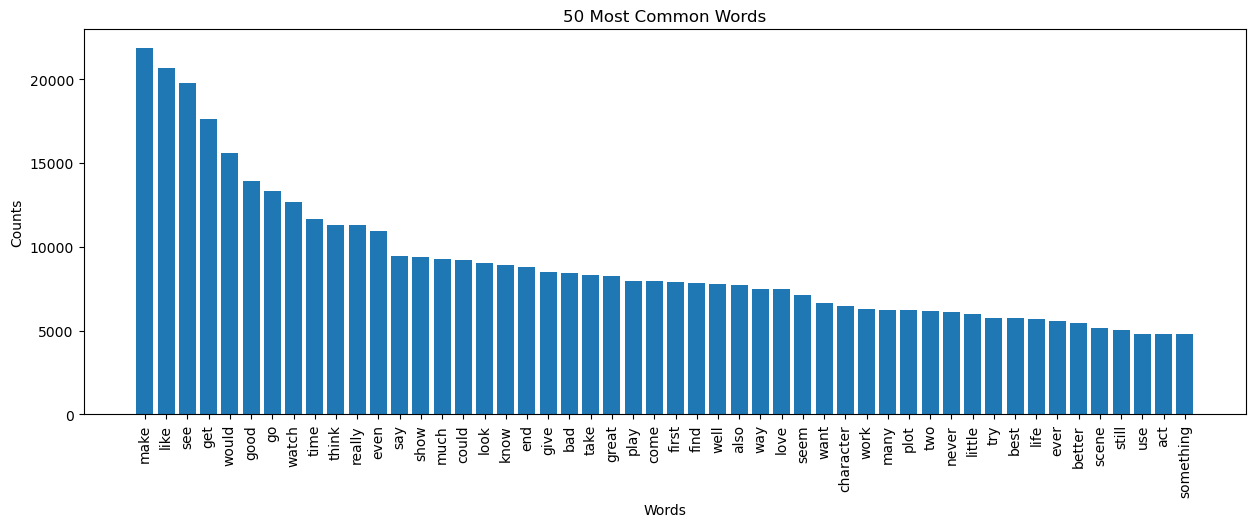

In [89]:
plot_most_common_words(df_train_visu, "train")

*Test set*.

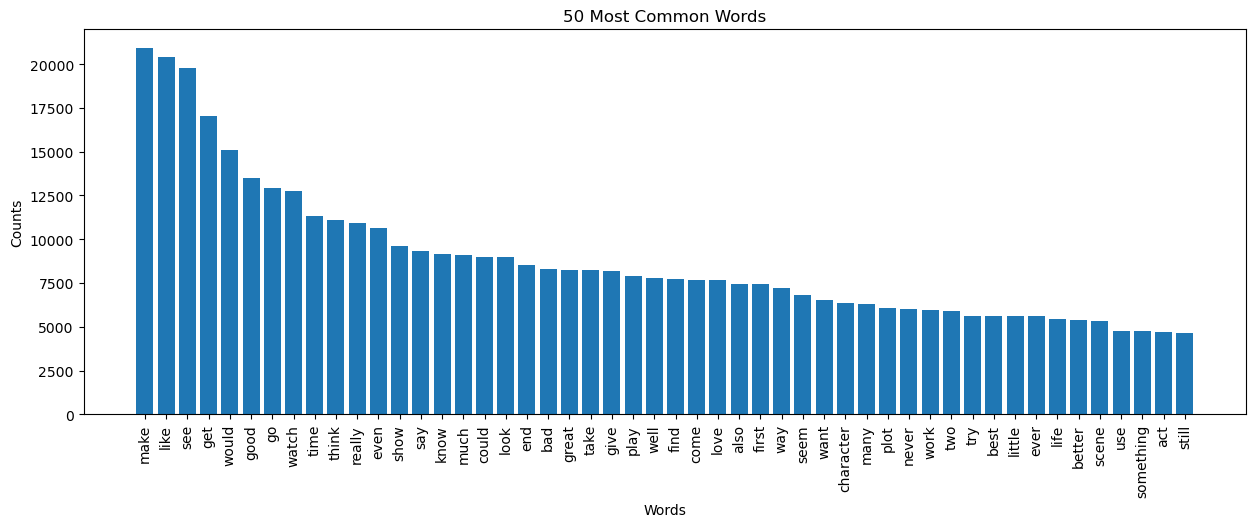

In [90]:
plot_most_common_words(df_test_visu, "test")

## Mots disjoint.

In [91]:
df_train_visu2 = copy.deepcopy(df_train_visu)
df_train_visu2 = remove_common_word(df_train_visu2)

2096005 words removed !


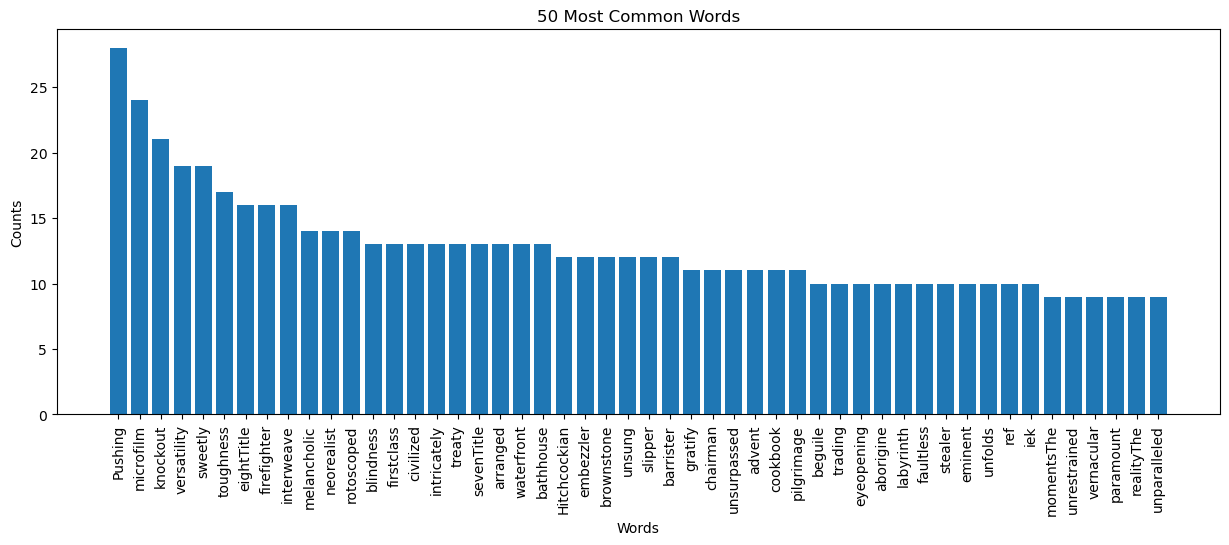

In [92]:
df_train_pos_visu = df_train_visu2[df_train_visu2["sentiment"] == 1]
plot_most_common_words(df_train_pos_visu, "train_pos")

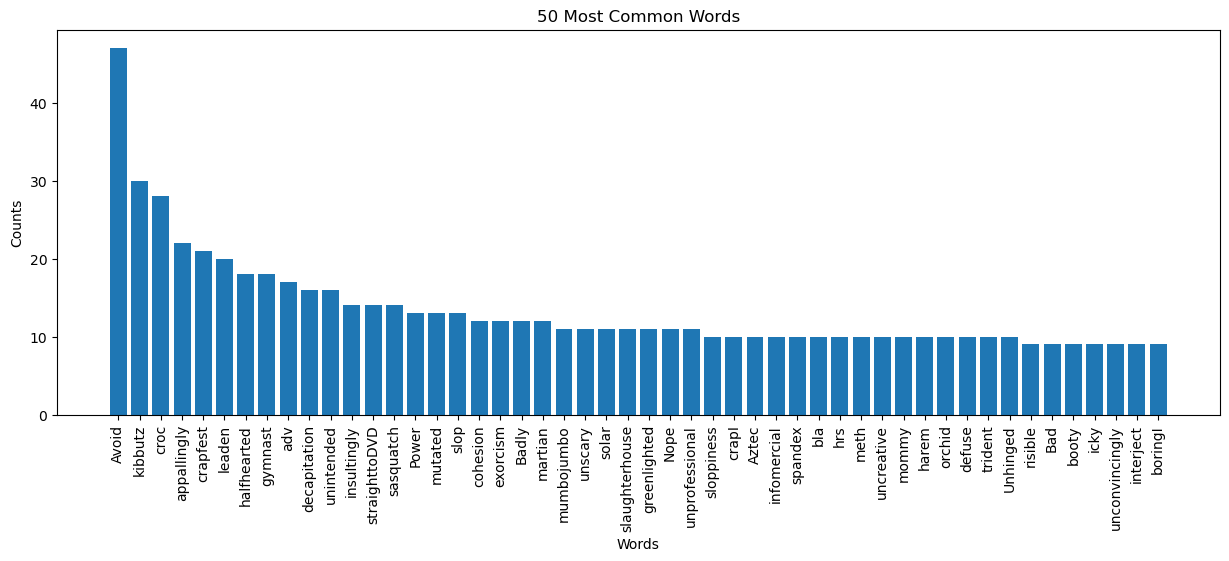

In [93]:
df_train_neg_visu = df_train_visu2[df_train_visu2["sentiment"] == 0]
plot_most_common_words(df_train_neg_visu, "train_neg")

## Mot commun positif.

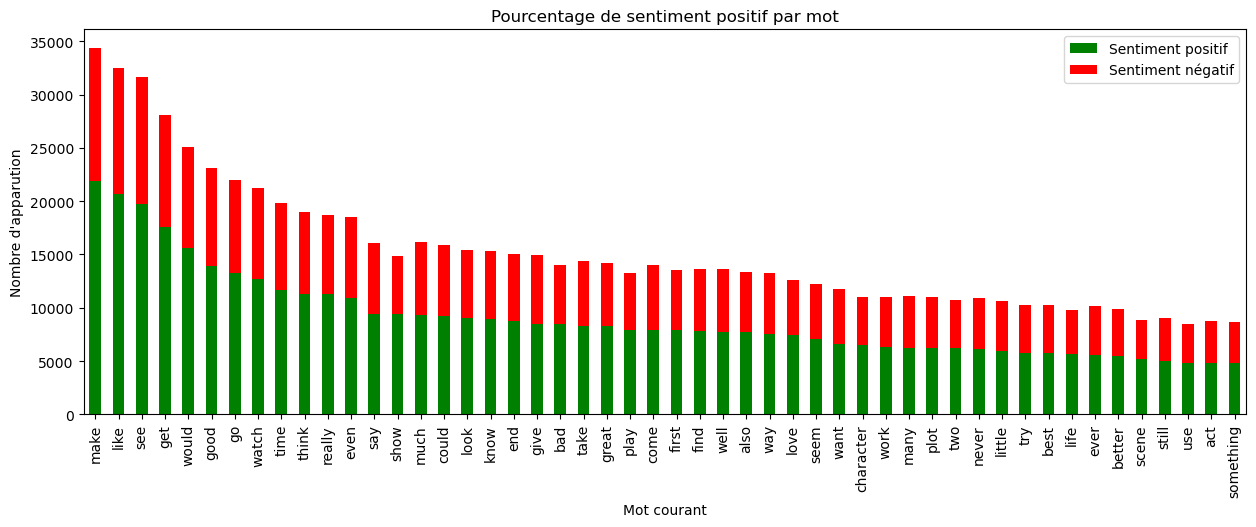

In [94]:
plot_most_common_words_pos(df_train_visu, "train")

## Nuage de mots.

*Train set*

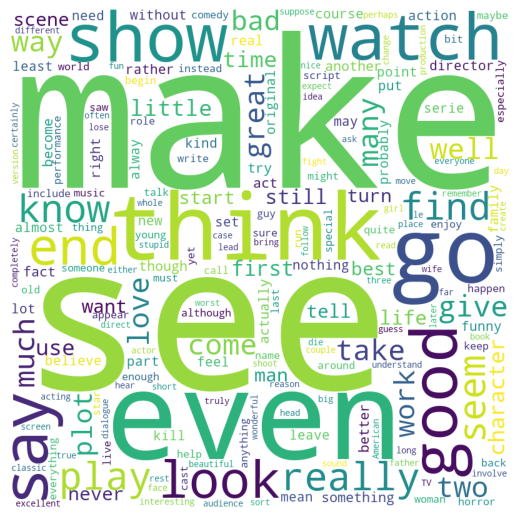

In [95]:
my_word_cloud(df_train_visu, "train")

*Test set*

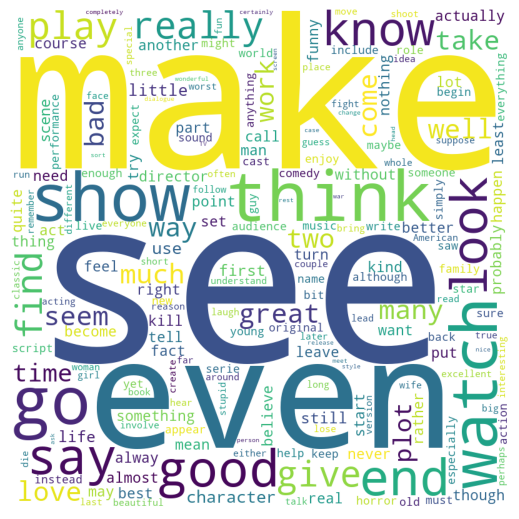

In [96]:
my_word_cloud(df_test_visu, "test")

# Classification.

In [97]:
df_train_classify = pd.read_csv(f"{OUT_CSV}df_train_prepro.csv")
df_test_classify = pd.read_csv(f"{OUT_CSV}df_test_prepro.csv")

In [98]:
classifiers = {
    "LogisticRegression": LogisticRegression(), # 87%
    "MultinomialNB": MultinomialNB(), # 85%
    "ComplementNB": ComplementNB(), # 85%
    "BernoulliNB": BernoulliNB(), # 84%
    # "RandomForestClassifier": RandomForestClassifier(), # 83%
    # "AdaBoostClassifier": AdaBoostClassifier(), # 80%
    # "KNeighborsClassifier": KNeighborsClassifier(), # 71%
    # "DecisionTreeClassifier": DecisionTreeClassifier(), # 70%
}

## Découpage en X et y.

In [99]:
X_train, y_train = df_train_classify["review"].values, df_train_classify["sentiment"].values
X_test, y_test = df_test_classify["review"].values, df_test_classify["sentiment"].values

## Paramètre par défaut.

### Entrainement.

In [100]:
liste_predictions = entrainement(classifiers, X_train, X_test, y_train, y_test)

LogisticRegression
fitting...Done
predicting labels...Done

MultinomialNB
fitting...Done
predicting labels...Done

ComplementNB
fitting...Done
predicting labels...Done

BernoulliNB
fitting...Done
predicting labels...Done



### Evaluation.

Rapport de classification pour LogisticRegression
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     12500
           1       0.86      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



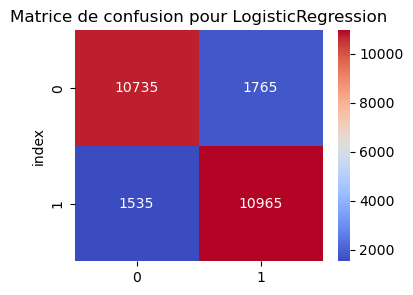

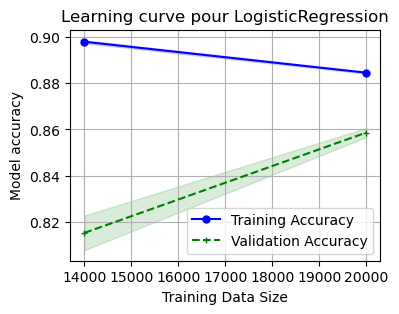

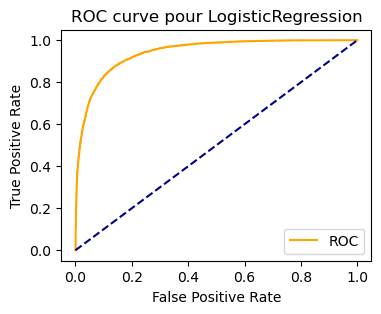

Rapport de classification pour MultinomialNB
              precision    recall  f1-score   support

           0       0.85      0.84      0.85     12500
           1       0.84      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



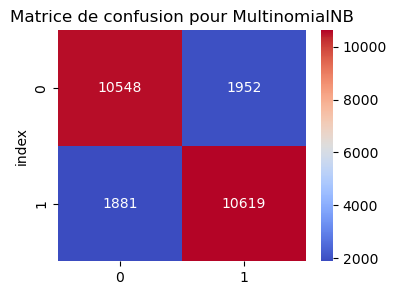

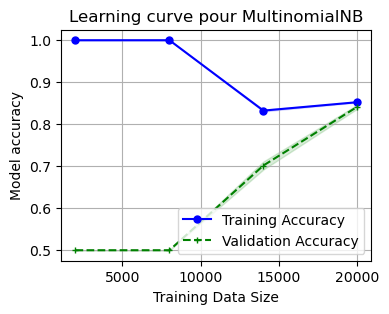

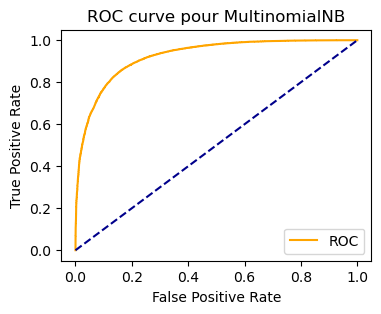

Rapport de classification pour ComplementNB
              precision    recall  f1-score   support

           0       0.85      0.84      0.85     12500
           1       0.84      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



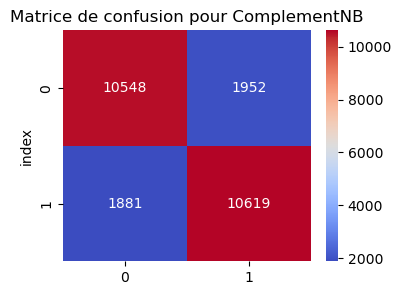

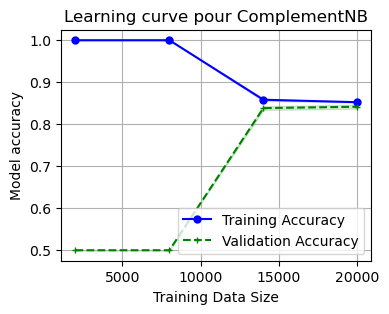

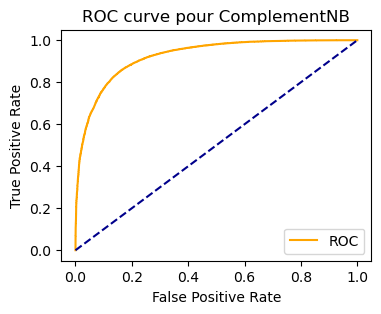

Rapport de classification pour BernoulliNB
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     12500
           1       0.84      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



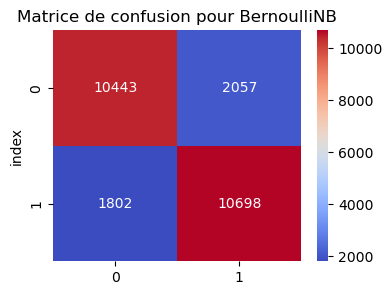

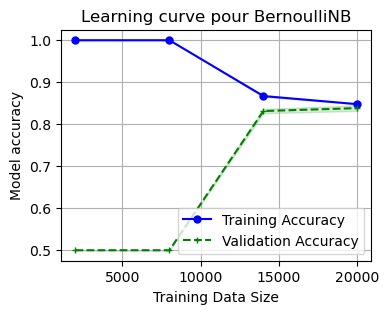

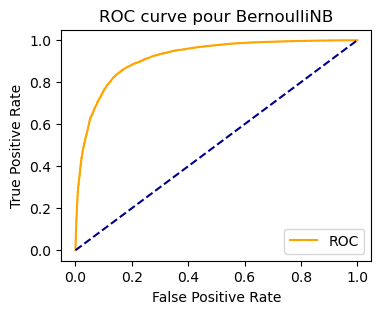

In [101]:
evaluation(liste_predictions, df_test_classify, "sentiment", X_train, X_test, y_train, y_test)

## Comparaison.

### Matrice de confusion.

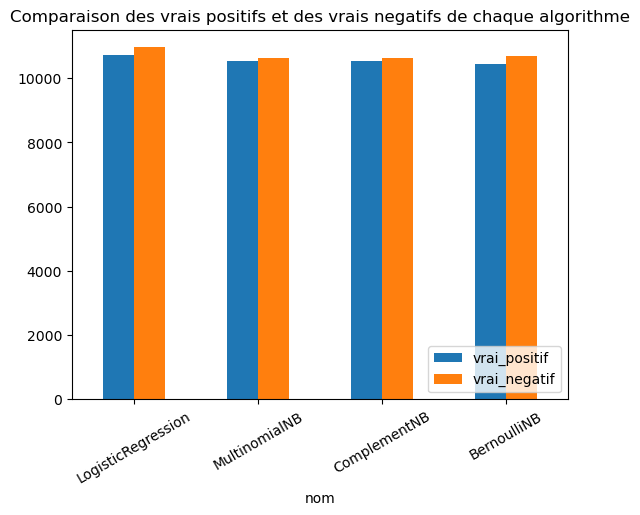

In [102]:
noms = []
vrai_positif = []
vrai_negatif = []
for nom, _, y_pred_test in liste_predictions:
	labels = np.unique(df_train_classify["sentiment"].values)
	conf_matrix = confusion_matrix(y_test, y_pred_test, labels=labels)

	noms.append(nom)
	vrai_positif.append(conf_matrix[0][0])
	vrai_negatif.append(conf_matrix[1][1])

data = {"nom": noms, "vrai_positif": vrai_positif, "vrai_negatif": vrai_negatif}
df_matric_confu = pd.DataFrame(data, columns=["nom", "vrai_positif", "vrai_negatif"])
df_matric_confu.plot.bar(x="nom", rot=30, title="Comparaison des vrais positifs et des vrais negatifs de chaque algorithme")
plt.legend(loc="lower right")
plt.savefig(f"{OUT_IMG}comparaison_matrice_confusion.png", bbox_inches='tight')
plt.show()

### *ROC curve*.

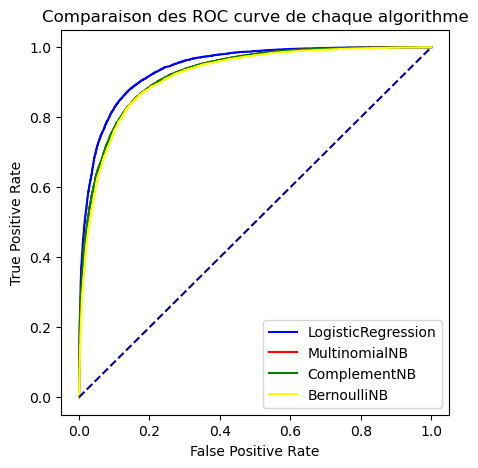

In [103]:
plt.figure(figsize=(5,5))
for index, (nom, model_fit, _) in enumerate(liste_predictions):
	colors = ["blue", "red", "green", "yellow"]
	probs = model_fit.predict_proba(X_test) 
	probs = probs[:, 1]
	fper, tper, thresholds = roc_curve(y_test, probs) 
	plt.plot(fper, tper, color=colors[index], label=f"{nom}")

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Comparaison des ROC curve de chaque algorithme")
plt.legend()
plt.savefig(f"{OUT_IMG}comparaison_roc_curve.png", bbox_inches='tight')
plt.show()

## Amélioration des paramètres.

In [104]:
model = Pipeline([
	("vectorize", CountVectorizer()),
	("tfidf", TfidfTransformer()),
	("logistic", LogisticRegression(max_iter=2000)),
])

max_features = [1000, 1500, 3000]
c = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tdidf = ["l1","l2"]

param_grid_lbfgs = {
	"vectorize__max_features": max_features,
	"tfidf__norm": tdidf,
	"logistic__penalty": ["l2"],
	"logistic__C": c,
	"logistic__solver": ["lbfgs"]
}

param_grid_sag= {
	"vectorize__max_features": max_features,
	"tfidf__norm": tdidf,
	"logistic__penalty": ["l2"],
	"logistic__C": c,
	"logistic__solver": ["sag"]
}

param_grid_saga= {
	"vectorize__max_features": max_features,
	"tfidf__norm": tdidf,
	"logistic__penalty": ["elasticnet", "l1", "l2"],
	"logistic__C": c,
	"logistic__solver": ["saga"]
}

param_grid = [param_grid_lbfgs, param_grid_sag, param_grid_sag]
grid = RandomizedSearchCV(model, param_grid, n_iter=50)
# grid = GridSearchCV(model, param_grid)
grid.fit(X_train, y_train)
grid.best_estimator_

Pipeline(steps=[('vectorize', CountVectorizer(max_features=3000)),
                ('tfidf', TfidfTransformer()),
                ('logistic', LogisticRegression(C=1, max_iter=2000))])

### Entrainement.

In [105]:
# grid.best_estimator_
# Pipeline(steps=[('vectorize', CountVectorizer(max_features=3000)),
#                 ('tfidf', TfidfTransformer()),
#                 ('logistic', LogisticRegression(C=10, max_iter=1000, solver='sag'))])

best_model = grid.best_estimator_

print("fitting...", end="")
best_model.fit(X_train, y_train)
print("Done")

print("predicting labels...", end="")
y_pred = best_model.predict(X_test)
print("Done")

fitting...Done
predicting labels...Done


### Evaluation.

In [106]:
my_classification_report("LogisticRegression", y_pred, y_test)

Rapport de classification pour LogisticRegression
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     12500
           1       0.87      0.88      0.88     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

